In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

FILEMAP = {
    'BTC' : r'../resources/data/raw/BTC_USDT_1m.csv',
    'ADA' : r'../resources/data/raw/ADA_USDT_1m.csv',
    'ALGO' : r'../resources/data/raw/ALGO_USDT_1m.csv',
    'ANKR': r'../resources/data/raw/ANKR_USDT_1m.csv',
}

COL_PRICE    = 'close'      # ценовата колона в CSV-то
TIMEZONE     = 'UTC'        # всички в UTC
RISK_FREE    = 0.00         # годишен r_f; 0.0 ако не ти трябва
WEIGHT_CAP   = 0.50         # ≤ 50 % в един актив
N_PORTFOLIOS = 25_000       # Монте Карло проби
SEED         = 42
np.random.seed(SEED)

# --- 1-минутни барове → 525 600 на година ----------------------------
BAR_SEC           = 60
PERIODS_PER_YEAR  = int(365 * 86_400 / BAR_SEC) 
print(f'periods_per_year = {PERIODS_PER_YEAR:,}')

periods_per_year = 525,600


In [2]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 1) Зареждане на минутните цени                              ║
# ╚═════════════════════════════════════════════════════════════╝
def load_iso_csv(path: str | Path,
                 price_col: str = COL_PRICE,
                 tz: str = TIMEZONE) -> pd.Series:
    """
    Чете CSV с ISO `timestamp` и връща Series<price> (tz-aware).
    """
    df = pd.read_csv(path,
                     parse_dates=['timestamp'],
                     index_col='timestamp')
    df.index = df.index.tz_localize(tz)
    return df[price_col].astype(float)


# --- комбинираме всички активи ----------------------------------------
prices = pd.concat(
    {tkr: load_iso_csv(p) for tkr, p in FILEMAP.items()},
    axis=1,
    join='inner'                   # пазим минутите, налични за всички
).sort_index()

print(prices.head())

                                BTC     ADA    ALGO     ANKR
timestamp                                                   
2023-06-09 12:18:00+00:00  26640.01  0.3184  0.1254  0.02374
2023-06-09 12:19:00+00:00  26654.99  0.3186  0.1254  0.02376
2023-06-09 12:20:00+00:00  26661.16  0.3185  0.1255  0.02379
2023-06-09 12:21:00+00:00  26643.89  0.3196  0.1254  0.02375
2023-06-09 12:22:00+00:00  26632.23  0.3204  0.1253  0.02373


In [3]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 2) Минутни доходности, μ̅, Σ                                ║
# ╚═════════════════════════════════════════════════════════════╝
rets = prices.pct_change().dropna()

# проверка, че са 1-минутни
freq = rets.index.to_series().diff().dt.total_seconds().median()
assert freq == BAR_SEC, f'Открих {freq=} сек. – не е 1-мин серия!'

means_bar = rets.mean().values                  # μ_i  (за 1 бар)
cov_bar   = rets.cov().values                  # Σ    (за 1 бар)
print(cov_bar)
tickers   = list(FILEMAP.keys())

# кратка статистика
stats = pd.DataFrame({'μ_bar': means_bar,
                      'σ_bar': rets.std(ddof=0).values},
                     index=tickers)
stats['Sharpe_bar'] = stats['μ_bar'] / stats['σ_bar']
display(stats)


[[4.32254579e-07 4.76544906e-07 4.89541909e-07 4.69839819e-07]
 [4.76544906e-07 1.27734268e-06 9.41577231e-07 8.94176147e-07]
 [4.89541909e-07 9.41577231e-07 1.78329484e-06 1.03306919e-06]
 [4.69839819e-07 8.94176147e-07 1.03306919e-06 2.05604197e-06]]


,μ_bar,σ_bar,Sharpe_bar
BTC,0.000002,0.000657,0.003098
ADA,0.000001,0.001130,0.001093
ALGO,0.000001,0.001335,0.001096
ANKR,0.000002,0.001434,0.001382


In [4]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 3) Монте-Карло портфейли (с ограничение на теглото)         ║
# ╚═════════════════════════════════════════════════════════════╝
n_assets = len(tickers)
results  = np.zeros((3, N_PORTFOLIOS))          # σ, μ, Sharpe
weights  = np.zeros((N_PORTFOLIOS, n_assets))

i = 0
while i < N_PORTFOLIOS:
    w = np.random.random(n_assets)
    w /= w.sum()
    if (w > WEIGHT_CAP).any():          # концентрационен лимит
        continue

    mu_bar  = np.dot(w, means_bar)
    sig_bar = np.sqrt(w @ cov_bar @ w)

    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)

    weights[i]   = w
    results[0,i] = sig_ann
    results[1,i] = mu_ann
    results[2,i] = (mu_ann - RISK_FREE) / sig_ann

    i += 1

idx_max_sharpe = results[2].argmax()
idx_min_vol    = results[0].argmin()


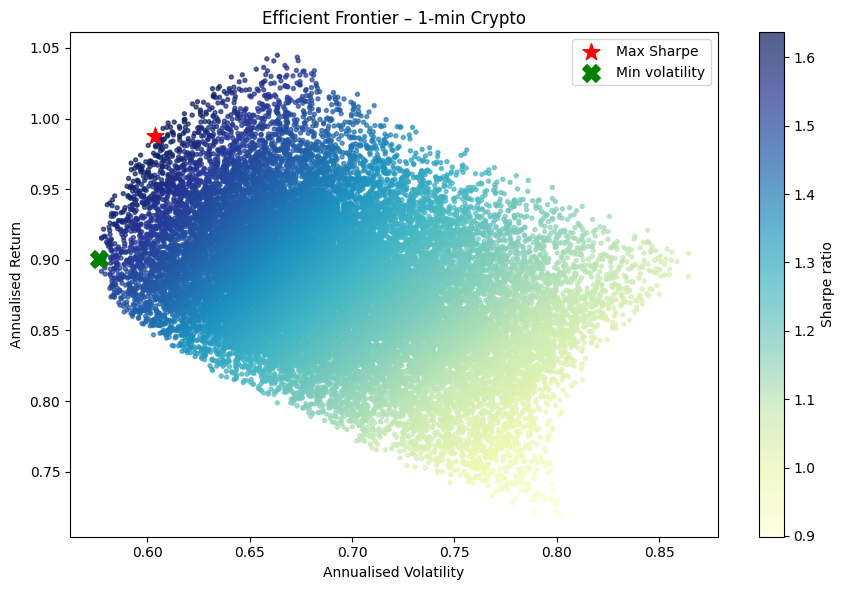

In [5]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 4) Графика: Efficient Frontier                             ║
# ╚═════════════════════════════════════════════════════════════╝
fig, ax = plt.subplots(figsize=(9, 6))
sc = ax.scatter(results[0], results[1],
                c=results[2], cmap='YlGnBu', s=8, alpha=0.7)
fig.colorbar(sc, label='Sharpe ratio')

ax.scatter(*results[:2, idx_max_sharpe],
           marker='*', s=160, color='r', label='Max Sharpe')
ax.scatter(*results[:2, idx_min_vol],
           marker='X', s=160, color='g', label='Min volatility')

ax.set(title='Efficient Frontier – 1-min Crypto',
       xlabel='Annualised Volatility',
       ylabel='Annualised Return')
ax.legend(); plt.tight_layout()


In [6]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 5) Показване на разпределенията                             ║
# ╚═════════════════════════════════════════════════════════════╝
alloc_max = pd.Series(weights[idx_max_sharpe], index=tickers).round(2)
alloc_min = pd.Series(weights[idx_min_vol   ], index=tickers).round(2)

print('\n' + '─'*70)
print('ПОРТФЕЙЛ С МАКС. SHARPE')
print(f"  Год. доходност : {results[1, idx_max_sharpe]:.2%}")
print(f"  Год. волатилност : {results[0, idx_max_sharpe]:.2%}\n")
display(alloc_max.to_frame('Weight').T)

print('\n' + '─'*70)
print('ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ')
print(f"  Год. доходност : {results[1, idx_min_vol]:.2%}")
print(f"  Год. волатилност : {results[0, idx_min_vol]:.2%}\n")
display(alloc_min.to_frame('Weight').T)



──────────────────────────────────────────────────────────────────────
ПОРТФЕЙЛ С МАКС. SHARPE
  Год. доходност : 98.79%
  Год. волатилност : 60.37%



,BTC,ADA,ALGO,ANKR
Weight,0.5,0.11,0.09,0.3



──────────────────────────────────────────────────────────────────────
ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ
  Год. доходност : 90.08%
  Год. волатилност : 57.66%



,BTC,ADA,ALGO,ANKR
Weight,0.5,0.31,0.12,0.07


In [8]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 6) Генетичен алгоритъм – оптимизация на Sharpe              ║
# ╚═════════════════════════════════════════════════════════════╝
import random

# --------------------------------------------------------------
# Хиперпараметри на GA
# --------------------------------------------------------------
POP_SIZE       = 1000          # колко индивида във всяко поколение
NB_GENERATIONS = 50             # колко поколения
ELITE_FRAC     = 0.10           # най-добрият % индивиди, които копираме директно
MUTATE_FRAC    = 0.15           # шанс дадено дете да бъде мутант
MUTATE_SCALE   = 0.10           # колко силно „рита“ мутантът теглото
PLOT_X = 5
PLOT_Y = 5


np.random.seed(123)

# --------------------------------------------------------------
# Фитнес функция – годишен Sharpe
# --------------------------------------------------------------
def fitness(w: np.ndarray) -> float:
    """
    w трябва вече да е нормализиран: Σ w_i = 1
    """
    mu_bar  = w @ means_bar
    sig_bar = np.sqrt(w @ cov_bar @ w)
    
    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)
    return (mu_ann - RISK_FREE) / sig_ann


# --------------------------------------------------------------
# GA инструменти: кросоувър, мутация, създаване на поколение
# --------------------------------------------------------------
def crossover(p1: np.ndarray, p2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Симпъл α-crossover (α ~ U[0,1])
    """
    α = np.random.rand()
    c1 = α * p1 + (1 - α) * p2
    c2 = (1 - α) * p1 + α * p2
    return c1, c2

def mutate(child: np.ndarray) -> np.ndarray:
    """
    Избутва случайно тегло с N(0, MUTATE_SCALE).
    После нормализира и реже до WEIGHT_CAP.
    """
    idx = np.random.randint(len(child))
    child[idx] += np.random.normal(0, MUTATE_SCALE)
    child = np.clip(child, 0, WEIGHT_CAP)      # защитно изрязване
    child /= child.sum()
    return child

def next_generation(pop: list[np.ndarray]) -> list[np.ndarray]:
    """
    Създава следващото поколение:
      1. сортира по fitness (низходящ)
      2. взема ELITE_FRAC като “елит”
      3. прави деца чрез кросоувър
      4. мутира част от децата
      5. нормализира теглата
    """
    pop = sorted(pop, key=fitness, reverse=True)
    elite_n = int(len(pop) * ELITE_FRAC)
    new_pop = pop[:elite_n]                       # запазваме елита
    
    # ––– рандомизираме елита, за да правим случайни двойки
    random.shuffle(new_pop)
    parents = new_pop.copy()
    
    # ––– кросоувър
    children = []
    for p1, p2 in zip(parents[::2], parents[1::2]):
        c1, c2 = crossover(p1, p2)
        children.extend([c1, c2])
    
    # ––– мутации
    for k in range(len(children)):
        if np.random.rand() < MUTATE_FRAC:
            children[k] = mutate(children[k])
        # задължителна нормализация + cap
        children[k] = np.clip(children[k], 0, WEIGHT_CAP)
        children[k] /= children[k].sum()
    
    new_pop.extend(children)
    
    # ако популацията е недостатъчна (нечетен брой родители)
    while len(new_pop) < POP_SIZE:
        w = np.random.random(len(tickers))
        w /= w.sum()
        if (w > WEIGHT_CAP).any():
            continue
        new_pop.append(w)
    return new_pop[:POP_SIZE]


# hyperparameters optimizer
import numpy as np, random, math, optuna, time
from copy import deepcopy
def run_ga_once(pop_size, nb_generations, elite_frac,
                mutate_frac, mutate_scale,
                weight_cap, seed=None):
    """
    Стартира ЕДНО изпълнение на GA с подадените хиперпараметри.
    Връща Sharpe на най-добрия индивид.
    """

    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # -------------- локални override-и на глобалните константи --------------
    global POP_SIZE, NB_GENERATIONS, ELITE_FRAC
    global MUTATE_FRAC, MUTATE_SCALE, WEIGHT_CAP

    POP_SIZE       = pop_size
    NB_GENERATIONS = nb_generations
    ELITE_FRAC     = elite_frac
    MUTATE_FRAC    = mutate_frac
    MUTATE_SCALE   = mutate_scale
    WEIGHT_CAP     = weight_cap          # нов параметър!

    # -------------- инициализираме първото поколение ------------------------
    population = []
    while len(population) < POP_SIZE:
        w = np.random.random(len(tickers))
        w /= w.sum()
        if (w > WEIGHT_CAP).any():
            continue
        population.append(w)

    # -------------- еволюираме ----------------------------------------------
    best_fit = -math.inf
    for g in range(NB_GENERATIONS):
        population = next_generation(population)
        # оценяваме елита
        top = max(population, key=fitness)
        best_fit = max(best_fit, fitness(top))

    return best_fit   # ↑ Sharpe на най-силния индивид

def objective(trial: optuna.trial.Trial) -> float:
    """
    Optuna ще пробва различни GA-хиперпараметри и ще
    връща >>средния<< Sharpe от K рестарта на GA.
    """
    # 1) дефинираме търсено пространство
    pop_size       = trial.suggest_int   ('pop_size',        200, 1500, step=100)
    nb_generations = trial.suggest_int   ('nb_generations',   20, 200,  step=10)
    elite_frac     = trial.suggest_float ('elite_frac',      0.05, 0.35)
    mutate_frac    = trial.suggest_float ('mutate_frac',     0.05, 0.40)
    mutate_scale   = trial.suggest_float ('mutate_scale',    0.01, 0.50, log=True)
    weight_cap     = trial.suggest_float ('weight_cap',      0.30, 0.70)

    # 2) за стабилност ‒ стартираме GA K пъти с разл. seed
    K, scores = 3, []
    for k in range(K):
        seed = 2024 + k
        score = run_ga_once(pop_size, nb_generations,
                            elite_frac, mutate_frac, mutate_scale,
                            weight_cap, seed=seed)
        scores.append(score)

    # 3) Optuna максимизира -> връщаме средната стойност
    return float(np.mean(scores))

study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(),
                            pruner =optuna.pruners.MedianPruner(
                                        n_startup_trials=10, n_warmup_steps=5))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
study.optimize(objective,
               n_trials = 40,          # или по време: timeout=3600
               show_progress_bar=True)

print("🏆 Най-добрите GA-хиперпараметри:")
for k, v in study.best_trial.params.items():
    print(f"  {k:15s} : {v}")
print("Среден Sharpe  :", study.best_value)




[I 2025-06-27 21:36:36,321] A new study created in memory with name: no-name-141a004d-503c-46e5-93aa-025c71ccad37
Best trial: 0. Best value: 1.91485:   2%|██▉                                                                                                                 | 1/40 [00:18<11:53, 18.31s/it]

[I 2025-06-27 21:36:54,620] Trial 0 finished with value: 1.9148503693237802 and parameters: {'pop_size': 1300, 'nb_generations': 170, 'elite_frac': 0.31175372757520925, 'mutate_frac': 0.33935559049555747, 'mutate_scale': 0.016500843707905263, 'weight_cap': 0.6515179151707886}. Best is trial 0 with value: 1.9148503693237802.


Best trial: 1. Best value: 2.24462:   5%|█████▊                                                                                                              | 2/40 [00:22<06:18,  9.96s/it]

[I 2025-06-27 21:36:58,741] Trial 1 finished with value: 2.244621113661075 and parameters: {'pop_size': 1000, 'nb_generations': 50, 'elite_frac': 0.26379030976157225, 'mutate_frac': 0.28913792390552795, 'mutate_scale': 0.21045173108248827, 'weight_cap': 0.6688916372991749}. Best is trial 1 with value: 2.244621113661075.


Best trial: 1. Best value: 2.24462:   8%|████████▋                                                                                                           | 3/40 [00:27<04:48,  7.81s/it]

[I 2025-06-27 21:37:03,994] Trial 2 finished with value: 1.5516082756837337 and parameters: {'pop_size': 600, 'nb_generations': 80, 'elite_frac': 0.07054656531657233, 'mutate_frac': 0.1647297881927725, 'mutate_scale': 0.05780573037309031, 'weight_cap': 0.4029725956873666}. Best is trial 1 with value: 2.244621113661075.


Best trial: 1. Best value: 2.24462:  10%|███████████▌                                                                                                        | 4/40 [00:31<03:39,  6.10s/it]

[I 2025-06-27 21:37:07,476] Trial 3 finished with value: 1.7200775933478774 and parameters: {'pop_size': 300, 'nb_generations': 130, 'elite_frac': 0.19545620902989375, 'mutate_frac': 0.23754420941435855, 'mutate_scale': 0.04396741305325146, 'weight_cap': 0.5111437917465497}. Best is trial 1 with value: 2.244621113661075.


Best trial: 1. Best value: 2.24462:  12%|██████████████▌                                                                                                     | 5/40 [00:35<03:13,  5.52s/it]

[I 2025-06-27 21:37:11,975] Trial 4 finished with value: 1.8372317421129745 and parameters: {'pop_size': 1000, 'nb_generations': 50, 'elite_frac': 0.1536795433367244, 'mutate_frac': 0.33701234525993146, 'mutate_scale': 0.012155844705882768, 'weight_cap': 0.6215634408142152}. Best is trial 1 with value: 2.244621113661075.


Best trial: 1. Best value: 2.24462:  15%|█████████████████▍                                                                                                  | 6/40 [00:39<02:44,  4.85s/it]

[I 2025-06-27 21:37:15,506] Trial 5 finished with value: 1.559056783414105 and parameters: {'pop_size': 1200, 'nb_generations': 20, 'elite_frac': 0.30667818605253694, 'mutate_frac': 0.12958459906704933, 'mutate_scale': 0.14838701616796265, 'weight_cap': 0.33531075977139235}. Best is trial 1 with value: 2.244621113661075.


Best trial: 1. Best value: 2.24462:  18%|████████████████████▎                                                                                               | 7/40 [00:53<04:25,  8.05s/it]

[I 2025-06-27 21:37:30,145] Trial 6 finished with value: 1.7819825206203694 and parameters: {'pop_size': 800, 'nb_generations': 200, 'elite_frac': 0.0982150596238195, 'mutate_frac': 0.29468116150720813, 'mutate_scale': 0.041255012059448766, 'weight_cap': 0.5399106320021838}. Best is trial 1 with value: 2.244621113661075.


Best trial: 1. Best value: 2.24462:  20%|███████████████████████▏                                                                                            | 8/40 [01:00<04:02,  7.57s/it]

[I 2025-06-27 21:37:36,692] Trial 7 finished with value: 2.0462983210593975 and parameters: {'pop_size': 1200, 'nb_generations': 60, 'elite_frac': 0.05723825362671845, 'mutate_frac': 0.1775256471681435, 'mutate_scale': 0.12264221675017155, 'weight_cap': 0.5876628726171789}. Best is trial 1 with value: 2.244621113661075.


Best trial: 1. Best value: 2.24462:  22%|██████████████████████████                                                                                          | 9/40 [01:03<03:09,  6.10s/it]

[I 2025-06-27 21:37:39,552] Trial 8 finished with value: 1.7965331268139721 and parameters: {'pop_size': 1400, 'nb_generations': 20, 'elite_frac': 0.12984734084343383, 'mutate_frac': 0.1193698051790733, 'mutate_scale': 0.2799312243528066, 'weight_cap': 0.4218163596479813}. Best is trial 1 with value: 2.244621113661075.


Best trial: 1. Best value: 2.24462:  25%|████████████████████████████▊                                                                                      | 10/40 [01:12<03:32,  7.09s/it]

[I 2025-06-27 21:37:48,853] Trial 9 finished with value: 2.2008010114474796 and parameters: {'pop_size': 800, 'nb_generations': 130, 'elite_frac': 0.32477784797758463, 'mutate_frac': 0.2323919764039824, 'mutate_scale': 0.05144440172591475, 'weight_cap': 0.6907928827418476}. Best is trial 1 with value: 2.244621113661075.


Best trial: 1. Best value: 2.24462:  28%|███████████████████████████████▋                                                                                   | 11/40 [01:14<02:36,  5.40s/it]

[I 2025-06-27 21:37:50,422] Trial 10 finished with value: 2.2115801290512795 and parameters: {'pop_size': 200, 'nb_generations': 100, 'elite_frac': 0.24960064086282635, 'mutate_frac': 0.05397736245236487, 'mutate_scale': 0.3671861599636456, 'weight_cap': 0.697819429878468}. Best is trial 1 with value: 2.244621113661075.


Best trial: 1. Best value: 2.24462:  30%|██████████████████████████████████▌                                                                                | 12/40 [01:15<02:01,  4.33s/it]

[I 2025-06-27 21:37:52,302] Trial 11 finished with value: 2.2432260363678207 and parameters: {'pop_size': 200, 'nb_generations': 100, 'elite_frac': 0.25167625306346003, 'mutate_frac': 0.0757283902675897, 'mutate_scale': 0.4703606960074521, 'weight_cap': 0.6967526675000351}. Best is trial 1 with value: 2.244621113661075.


Best trial: 12. Best value: 2.24566:  32%|█████████████████████████████████████                                                                             | 13/40 [01:20<02:00,  4.45s/it]

[I 2025-06-27 21:37:57,049] Trial 12 finished with value: 2.245659143235646 and parameters: {'pop_size': 500, 'nb_generations': 100, 'elite_frac': 0.24818904471859576, 'mutate_frac': 0.2873042116839092, 'mutate_scale': 0.4929463161916105, 'weight_cap': 0.5791079937406236}. Best is trial 12 with value: 2.245659143235646.


Best trial: 12. Best value: 2.24566:  35%|███████████████████████████████████████▉                                                                          | 14/40 [01:23<01:42,  3.96s/it]

[I 2025-06-27 21:37:59,863] Trial 13 finished with value: 2.2024105571589505 and parameters: {'pop_size': 500, 'nb_generations': 60, 'elite_frac': 0.24535196088796782, 'mutate_frac': 0.2776371154700549, 'mutate_scale': 0.20200255079906818, 'weight_cap': 0.558585312479262}. Best is trial 12 with value: 2.245659143235646.


Best trial: 14. Best value: 2.2457:  38%|███████████████████████████████████████████▏                                                                       | 15/40 [01:36<02:47,  6.72s/it]

[I 2025-06-27 21:38:12,968] Trial 14 finished with value: 2.2456979533938815 and parameters: {'pop_size': 1000, 'nb_generations': 140, 'elite_frac': 0.21006994969958148, 'mutate_frac': 0.39707263707155804, 'mutate_scale': 0.09735407974808069, 'weight_cap': 0.6115160805340796}. Best is trial 14 with value: 2.2456979533938815.


Best trial: 14. Best value: 2.2457:  40%|██████████████████████████████████████████████                                                                     | 16/40 [01:43<02:45,  6.88s/it]

[I 2025-06-27 21:38:20,222] Trial 15 finished with value: 1.723507831659018 and parameters: {'pop_size': 500, 'nb_generations': 150, 'elite_frac': 0.19444192537197366, 'mutate_frac': 0.3940416598386435, 'mutate_scale': 0.08405570358822174, 'weight_cap': 0.45793785742164445}. Best is trial 14 with value: 2.2456979533938815.


Best trial: 14. Best value: 2.2457:  42%|████████████████████████████████████████████████▉                                                                  | 17/40 [01:54<03:06,  8.13s/it]

[I 2025-06-27 21:38:31,259] Trial 16 finished with value: 1.8666380657582051 and parameters: {'pop_size': 700, 'nb_generations': 180, 'elite_frac': 0.21319928198645433, 'mutate_frac': 0.38255519995643095, 'mutate_scale': 0.02534140214812832, 'weight_cap': 0.6058612476099565}. Best is trial 14 with value: 2.2456979533938815.


Best trial: 14. Best value: 2.2457:  45%|███████████████████████████████████████████████████▊                                                               | 18/40 [02:06<03:21,  9.14s/it]

[I 2025-06-27 21:38:42,743] Trial 17 finished with value: 1.8276860548533955 and parameters: {'pop_size': 1000, 'nb_generations': 130, 'elite_frac': 0.15520426472008397, 'mutate_frac': 0.34927662639323664, 'mutate_scale': 0.09969811490012613, 'weight_cap': 0.47805972420127296}. Best is trial 14 with value: 2.2456979533938815.


Best trial: 14. Best value: 2.2457:  48%|██████████████████████████████████████████████████████▋                                                            | 19/40 [02:11<02:49,  8.05s/it]

[I 2025-06-27 21:38:48,259] Trial 18 finished with value: 1.7853105853275189 and parameters: {'pop_size': 400, 'nb_generations': 160, 'elite_frac': 0.22355106162279753, 'mutate_frac': 0.3164667281031496, 'mutate_scale': 0.02842309874405559, 'weight_cap': 0.5605274058048674}. Best is trial 14 with value: 2.2456979533938815.


Best trial: 19. Best value: 2.24593:  50%|█████████████████████████████████████████████████████████                                                         | 20/40 [02:20<02:43,  8.16s/it]

[I 2025-06-27 21:38:56,671] Trial 19 finished with value: 2.2459322896610914 and parameters: {'pop_size': 900, 'nb_generations': 110, 'elite_frac': 0.28772127742307063, 'mutate_frac': 0.25396902750577577, 'mutate_scale': 0.45514279757523124, 'weight_cap': 0.6342740409000395}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 19. Best value: 2.24593:  52%|███████████████████████████████████████████████████████████▊                                                      | 21/40 [02:34<03:07,  9.85s/it]

[I 2025-06-27 21:39:10,456] Trial 20 finished with value: 2.245874764556976 and parameters: {'pop_size': 1100, 'nb_generations': 140, 'elite_frac': 0.296143314318536, 'mutate_frac': 0.19360501961029006, 'mutate_scale': 0.17299513953827644, 'weight_cap': 0.6340550026910721}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 19. Best value: 2.24593:  55%|██████████████████████████████████████████████████████████████▋                                                   | 22/40 [02:46<03:13, 10.75s/it]

[I 2025-06-27 21:39:23,300] Trial 21 finished with value: 2.245785920563716 and parameters: {'pop_size': 1000, 'nb_generations': 140, 'elite_frac': 0.2880146309457771, 'mutate_frac': 0.19065392667222794, 'mutate_scale': 0.16557325602735212, 'weight_cap': 0.6432419015897903}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 19. Best value: 2.24593:  57%|█████████████████████████████████████████████████████████████████▌                                                | 23/40 [03:01<03:24, 12.03s/it]

[I 2025-06-27 21:39:38,318] Trial 22 finished with value: 2.2450059353668803 and parameters: {'pop_size': 1500, 'nb_generations': 120, 'elite_frac': 0.3476711661990147, 'mutate_frac': 0.19774043006583997, 'mutate_scale': 0.1871882888803894, 'weight_cap': 0.6389728998282885}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 19. Best value: 2.24593:  60%|████████████████████████████████████████████████████████████████████▍                                             | 24/40 [03:12<03:04, 11.53s/it]

[I 2025-06-27 21:39:48,690] Trial 23 finished with value: 2.245901780051311 and parameters: {'pop_size': 1100, 'nb_generations': 110, 'elite_frac': 0.2903213135481977, 'mutate_frac': 0.2552708286279604, 'mutate_scale': 0.2796436898195398, 'weight_cap': 0.6500551745979305}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 19. Best value: 2.24593:  62%|███████████████████████████████████████████████████████████████████████▎                                          | 25/40 [03:24<02:56, 11.77s/it]

[I 2025-06-27 21:40:01,001] Trial 24 finished with value: 2.243216554680728 and parameters: {'pop_size': 1200, 'nb_generations': 110, 'elite_frac': 0.2821994982400987, 'mutate_frac': 0.2545854127311121, 'mutate_scale': 0.31430787368783647, 'weight_cap': 0.5093562152688133}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 19. Best value: 2.24593:  65%|██████████████████████████████████████████████████████████████████████████                                        | 26/40 [03:32<02:29, 10.71s/it]

[I 2025-06-27 21:40:09,253] Trial 25 finished with value: 2.2443417801129777 and parameters: {'pop_size': 1100, 'nb_generations': 80, 'elite_frac': 0.3418952904212965, 'mutate_frac': 0.2191040159424168, 'mutate_scale': 0.24922557865209757, 'weight_cap': 0.649834406478355}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 19. Best value: 2.24593:  68%|████████████████████████████████████████████████████████████████████████████▉                                     | 27/40 [03:39<02:02,  9.44s/it]

[I 2025-06-27 21:40:15,732] Trial 26 finished with value: 2.243778858418507 and parameters: {'pop_size': 900, 'nb_generations': 80, 'elite_frac': 0.2815268535115654, 'mutate_frac': 0.2558183239194877, 'mutate_scale': 0.3824962488251407, 'weight_cap': 0.5967737010235591}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 19. Best value: 2.24593:  70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 28/40 [03:52<02:05, 10.50s/it]

[I 2025-06-27 21:40:28,701] Trial 27 finished with value: 2.245849776675731 and parameters: {'pop_size': 1300, 'nb_generations': 110, 'elite_frac': 0.31340792192150896, 'mutate_frac': 0.20998133551996903, 'mutate_scale': 0.2532310657081509, 'weight_cap': 0.6742166132318328}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 19. Best value: 2.24593:  72%|██████████████████████████████████████████████████████████████████████████████████▋                               | 29/40 [04:07<02:10, 11.91s/it]

[I 2025-06-27 21:40:43,893] Trial 28 finished with value: 2.245088614104016 and parameters: {'pop_size': 900, 'nb_generations': 190, 'elite_frac': 0.2933545553843725, 'mutate_frac': 0.16556792235474832, 'mutate_scale': 0.3418182616807387, 'weight_cap': 0.5319018467259753}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 19. Best value: 2.24593:  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 30/40 [05:03<04:12, 25.21s/it]

[I 2025-06-27 21:41:40,132] Trial 29 finished with value: 2.055796806861588 and parameters: {'pop_size': 1300, 'nb_generations': 170, 'elite_frac': 0.3192032110018884, 'mutate_frac': 0.13781579887856862, 'mutate_scale': 0.13483821064546198, 'weight_cap': 0.3043800295747954}. Best is trial 19 with value: 2.2459322896610914.


Best trial: 30. Best value: 2.24594:  78%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 31/40 [05:14<03:07, 20.82s/it]

[I 2025-06-27 21:41:50,716] Trial 30 finished with value: 2.245942268329094 and parameters: {'pop_size': 700, 'nb_generations': 160, 'elite_frac': 0.2698307510672239, 'mutate_frac': 0.25586094267468, 'mutate_scale': 0.49697106574140126, 'weight_cap': 0.629222677496304}. Best is trial 30 with value: 2.245942268329094.


Best trial: 30. Best value: 2.24594:  80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 32/40 [05:24<02:19, 17.49s/it]

[I 2025-06-27 21:42:00,451] Trial 31 finished with value: 2.2459344400882943 and parameters: {'pop_size': 700, 'nb_generations': 150, 'elite_frac': 0.2661940237440361, 'mutate_frac': 0.2600569972223196, 'mutate_scale': 0.4665957946991388, 'weight_cap': 0.6325151590897712}. Best is trial 30 with value: 2.245942268329094.


Best trial: 32. Best value: 2.24594:  82%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 33/40 [05:35<01:48, 15.51s/it]

[I 2025-06-27 21:42:11,320] Trial 32 finished with value: 2.245944249978248 and parameters: {'pop_size': 700, 'nb_generations': 160, 'elite_frac': 0.2307794979868022, 'mutate_frac': 0.2624984468959258, 'mutate_scale': 0.49900037884666953, 'weight_cap': 0.6729392342246912}. Best is trial 32 with value: 2.245944249978248.


Best trial: 33. Best value: 2.24594:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 34/40 [05:50<01:33, 15.61s/it]

[I 2025-06-27 21:42:27,185] Trial 33 finished with value: 2.2459448052411872 and parameters: {'pop_size': 700, 'nb_generations': 180, 'elite_frac': 0.26859960773028757, 'mutate_frac': 0.2647068050180207, 'mutate_scale': 0.42250768899364005, 'weight_cap': 0.6760008562925272}. Best is trial 33 with value: 2.2459448052411872.


Best trial: 34. Best value: 2.24594:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 35/40 [06:06<01:18, 15.70s/it]

[I 2025-06-27 21:42:43,075] Trial 34 finished with value: 2.2459448070077825 and parameters: {'pop_size': 700, 'nb_generations': 170, 'elite_frac': 0.22936331043744987, 'mutate_frac': 0.30820837105743404, 'mutate_scale': 0.4097441260467758, 'weight_cap': 0.67034690752981}. Best is trial 34 with value: 2.2459448070077825.


Best trial: 34. Best value: 2.24594:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 36/40 [06:19<00:59, 14.91s/it]

[I 2025-06-27 21:42:56,147] Trial 35 finished with value: 2.2459447993261303 and parameters: {'pop_size': 700, 'nb_generations': 170, 'elite_frac': 0.22896745120856918, 'mutate_frac': 0.32984345394222053, 'mutate_scale': 0.3762052396894697, 'weight_cap': 0.6656227668985731}. Best is trial 34 with value: 2.2459448070077825.


Best trial: 36. Best value: 2.24594:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 37/40 [06:31<00:41, 13.86s/it]

[I 2025-06-27 21:43:07,574] Trial 36 finished with value: 2.24594481143708 and parameters: {'pop_size': 600, 'nb_generations': 180, 'elite_frac': 0.1781320487006787, 'mutate_frac': 0.3144951174403416, 'mutate_scale': 0.22885536442423224, 'weight_cap': 0.6702392985555451}. Best is trial 36 with value: 2.24594481143708.


Best trial: 37. Best value: 2.24594:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 38/40 [06:42<00:25, 12.96s/it]

[I 2025-06-27 21:43:18,429] Trial 37 finished with value: 2.245944811958917 and parameters: {'pop_size': 600, 'nb_generations': 200, 'elite_frac': 0.17811642472255637, 'mutate_frac': 0.3207496150094618, 'mutate_scale': 0.22310671793134879, 'weight_cap': 0.6646672051006266}. Best is trial 37 with value: 2.245944811958917.


Best trial: 38. Best value: 2.24594:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [06:53<00:12, 12.45s/it]

[I 2025-06-27 21:43:29,679] Trial 38 finished with value: 2.2459448130818025 and parameters: {'pop_size': 600, 'nb_generations': 200, 'elite_frac': 0.17516861241267023, 'mutate_frac': 0.36157178218810304, 'mutate_scale': 0.22440480189467898, 'weight_cap': 0.6731088862538834}. Best is trial 38 with value: 2.2459448130818025.


Best trial: 38. Best value: 2.24594: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [07:05<00:00, 10.64s/it]

[I 2025-06-27 21:43:42,012] Trial 39 finished with value: 2.2459448130810906 and parameters: {'pop_size': 600, 'nb_generations': 200, 'elite_frac': 0.17492215983702178, 'mutate_frac': 0.36207266571645047, 'mutate_scale': 0.23274696925230418, 'weight_cap': 0.6627882324240267}. Best is trial 38 with value: 2.2459448130818025.
🏆 Най-добрите GA-хиперпараметри:
  pop_size        : 600
  nb_generations  : 200
  elite_frac      : 0.17516861241267023
  mutate_frac     : 0.36157178218810304
  mutate_scale    : 0.22440480189467898
  weight_cap      : 0.6731088862538834
Среден Sharpe  : 2.2459448130818025


In [11]:
    # POP_SIZE       = pop_size
    # NB_GENERATIONS = nb_generations
    # ELITE_FRAC     = elite_frac
    # MUTATE_FRAC    = mutate_frac
    # MUTATE_SCALE   = mutate_scale
    # WEIGHT_CAP     = weight_cap 
print("OPTIMIZED HYPERPARAMETERS")
print(f"POP_SIZE: {POP_SIZE}")
print(f"NB_GENERATIONS: {NB_GENERATIONS}")
print(f"ELITE_FRAC: {ELITE_FRAC}")
print(f"MUTATE_FRAC: {MUTATE_FRAC}")
print(f"MUTATE_SCALE: {MUTATE_SCALE}")
print(f"WEIGHT_CAP: {WEIGHT_CAP}")

OPTIMIZED HYPERPARAMETERS
POP_SIZE: 600
NB_GENERATIONS: 200
ELITE_FRAC: 0.17492215983702178
MUTATE_FRAC: 0.36207266571645047
MUTATE_SCALE: 0.23274696925230418
WEIGHT_CAP: 0.6627882324240267


Ще се визуализират поколения: [0, 8, 16, 24, 33, 41, 49, 58, 66, 74, 82, 91, 99, 107, 116, 124, 132, 140, 149, 157, 165, 174, 182, 190, 199]


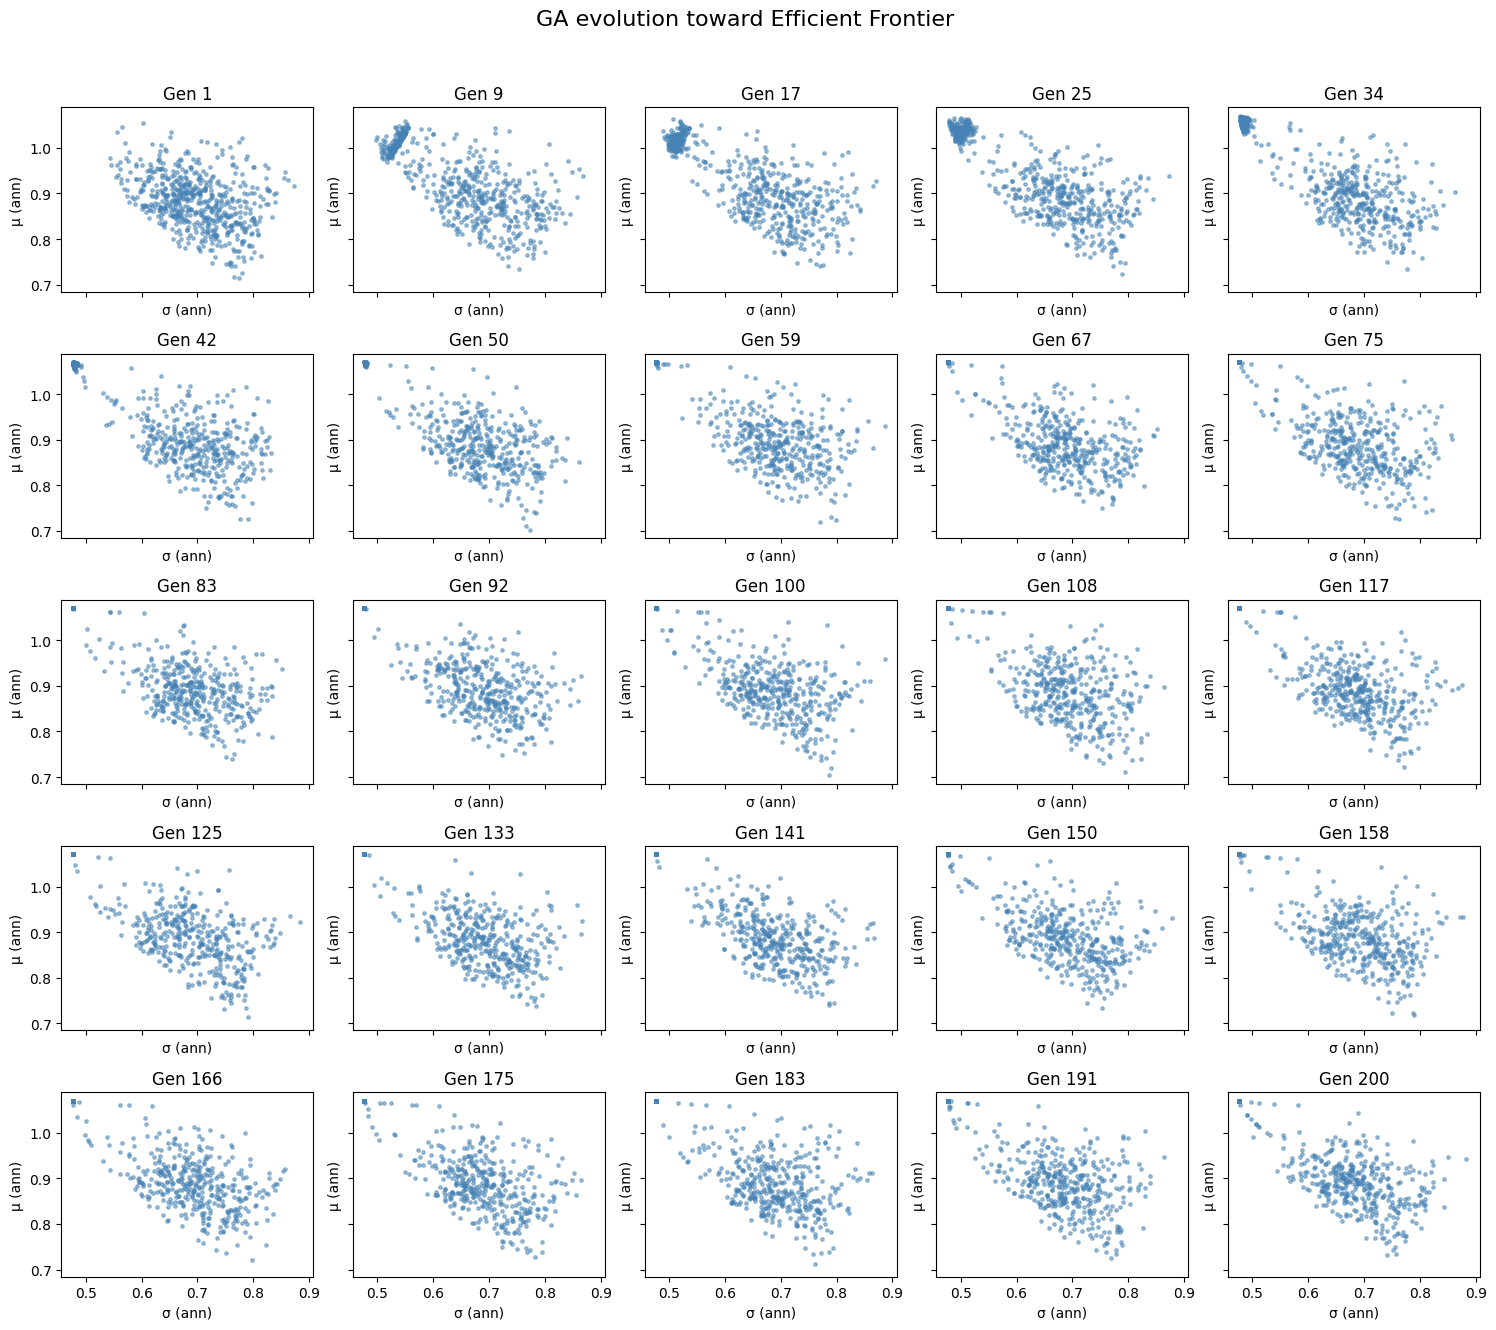

In [12]:
# --------------------------------------------------------------
# 6.1) Инициализация на първото поколение
# --------------------------------------------------------------
population = []
while len(population) < POP_SIZE:
    w = np.random.random(len(tickers))
    w /= w.sum()
    if (w > WEIGHT_CAP).any():
        continue
    population.append(w)

# --------------------------------------------------------------
# 6.2) Еволюция и визуализация
# --------------------------------------------------------------
# fig, axs = plt.subplots(PLOT_X, PLOT_Y, figsize=(15, 13), sharex=True, sharey=True)
# axs = axs.flatten()

fig, axs = plt.subplots(PLOT_Y, PLOT_X, figsize=(15, 13),
                        sharex=True, sharey=True)
axs = axs.flatten()
MAX_PLOTS = PLOT_X * PLOT_Y      # 25

# кои поколения ще рисуваме
if NB_GENERATIONS <= MAX_PLOTS:
    gens_to_plot = list(range(NB_GENERATIONS))
else:
    # равномерни индекси, винаги включва 0
    gens_to_plot = (np.linspace(0, NB_GENERATIONS - 1,
                                num=MAX_PLOTS, dtype=int)
                      .tolist())

print("Ще се визуализират поколения:", gens_to_plot)

for g in range(NB_GENERATIONS):
    # ── статистика за текущото поколение ───────────────────────
    res = np.zeros((2, POP_SIZE))            # σ, μ  (годишни)
    for i, w in enumerate(population):
        mu_bar  = w @ means_bar
        sig_bar = np.sqrt(w @ cov_bar @ w)
        res[1, i] = mu_bar  * PERIODS_PER_YEAR
        res[0, i] = sig_bar * np.sqrt(PERIODS_PER_YEAR)

    # ── чертаем само ако g e в списъка ──────────────────────────
    if g in gens_to_plot:
        plot_idx = gens_to_plot.index(g)     # 0 … 24
        ax = axs[plot_idx]
        ax.scatter(res[0], res[1], s=6, alpha=0.5, c='steelblue')
        ax.set_title(f'Gen {g+1}')
        ax.set_xlabel('σ (ann)')
        ax.set_ylabel('μ (ann)')

    # ── еволюираме към следващо поколение ───────────────────────
    population = next_generation(population)

plt.suptitle('GA evolution toward Efficient Frontier', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [13]:
TOP_N = 20        # how many best portfolios you want to list

def ann_stats(w: np.ndarray) -> tuple[float, float, float]:
    mu_bar  = w @ means_bar
    sig_bar = np.sqrt(w @ cov_bar @ w)
    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)
    sharpe  = (mu_ann - RISK_FREE) / sig_ann
    return mu_ann, sig_ann, sharpe

# 1) take the best TOP_N by Sharpe
best_pop = sorted(population, key=fitness, reverse=True)[:TOP_N]

# 2) build one combined table
records = []
for rank, w in enumerate(best_pop, 1):
    mu, sig, shp = ann_stats(w)
    rec = {
        'Rank'      : rank,
        'Annual μ'  : round(mu, 4),
        'Annual σ'  : round(sig, 4),
        'Sharpe'    : round(shp, 3)
    }
    # add the weights, rounded to 3 dp
    rec.update({tkr: round(w[i], 3) for i, tkr in enumerate(tickers)})
    records.append(rec)

top_df = (pd.DataFrame(records)
            .set_index('Rank')
            .sort_index())

display(top_df)


,Annual μ,Annual σ,Sharpe,BTC,ADA,ALGO,ANKR
Rank,,,,,,,
1,1.0705,0.4766,2.246,1.0,0.0,0.0,0.0
2,1.0705,0.4766,2.246,1.0,0.0,0.0,0.0
3,1.0705,0.4766,2.246,1.0,0.0,0.0,0.0
4,1.0705,0.4766,2.246,1.0,0.0,0.0,0.0
5,1.0705,0.4766,2.246,1.0,0.0,0.0,0.0
6,1.0705,0.4766,2.246,1.0,0.0,0.0,0.0
7,1.0705,0.4766,2.246,1.0,0.0,0.0,0.0
8,1.0705,0.4766,2.246,1.0,0.0,0.0,0.0
9,1.0705,0.4766,2.246,1.0,0.0,0.0,0.0


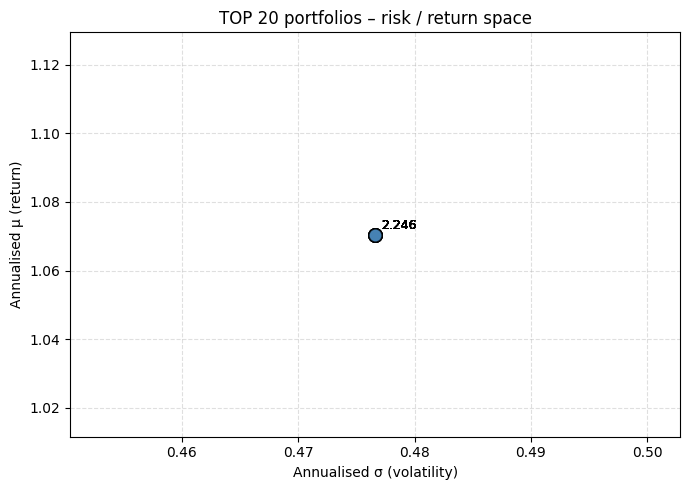

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(top_df['Annual σ'], top_df['Annual μ'],
            s=90, color='steelblue', edgecolors='k', alpha=0.8)

# (по желание) етикет към всяка точка – номерът в класацията
for rank, row in top_df.iterrows():
    plt.annotate(str(row['Sharpe']),
                 (row['Annual σ'], row['Annual μ']),
                 textcoords="offset points",
                 xytext=(4, 4), ha='left', fontsize=9)

plt.xlabel('Annualised σ (volatility)')
plt.ylabel('Annualised μ (return)')
plt.title(f'TOP {len(top_df)} portfolios – risk / return space')
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [17]:
best_w = top_df.iloc[0][tickers].to_dict()
best_w

# ПОРТФЕЙЛ С МАКС. SHARPE
#   Год. доходност : 98.79%
#   Год. волатилност : 60.37%

# BTC	ADA	ALGO	ANKR
# Weight	0.5	0.11	0.09	0.3

# ──────────────────────────────────────────────────────────────────────
# ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ
#   Год. доходност : 90.08%
#   Год. волатилност : 57.66%

# BTC	ADA	ALGO	ANKR
# Weight	0.5	0.31	0.12	0.07

{'BTC': 1.0, 'ADA': 0.0, 'ALGO': 0.0, 'ANKR': 0.0}

In [18]:
# -*- coding: utf-8 -*-
"""
Backtrader static-weight portfolio back-test
"""
import matplotlib
matplotlib.use('Agg')  
import backtrader as bt
import pandas as pd
from pathlib import Path


# ---------- Параметри ------------------------------------------------------

WEIGHTS = best_w

DATA_DIR       = Path('../resources/data/raw')   # коригирай пътя, ако е нужно
STARTING_CASH  = 100_000
COMMISSION     = 0.001        # 0.1 %
REBALANCE_DAYS = 30         # напр. 30 за месечен ребаланс


# ---------- Стратегия ------------------------------------------------------

class StaticWeightStrategy(bt.Strategy):
    """
    Поддържа фиксирани тегла. Ребалансира:
      • веднъж на първата свещ;
      • през `rebalance_days`, ако е зададено.
    """
    params = (
        ('weights',         None),
        ('rebalance_days',  None),
    )

    def __init__(self):
        self.rebalanced_init = False     # ще ребалансираме при първата свещ
        self.last_rebalance  = None      # календарно следене (ако е нужно)

    # --------------------------------------------------
    def next(self):
        dt = self.datas[0].datetime.date(0)   # текуща дата

        # --- първоначален ребаланс ---------------------------------
        if not self.rebalanced_init:
            self.rebalance()
            self.rebalanced_init = True
            self.last_rebalance  = dt
            return                          # излизаме, за да не удвоим ребаланса

        # --- периодичен ребаланс -----------------------------------
        if self.p.rebalance_days:
            if (dt - self.last_rebalance).days >= self.p.rebalance_days:
                self.rebalance()
                self.last_rebalance = dt

    # --------------------------------------------------
    def rebalance(self):
        """
        Изравняване на позициите към зададените тегла.
        """
        port_value = self.broker.getvalue()
        for data in self.datas:
            w = self.p.weights.get(data._name, 0.0)
            self.order_target_percent(data=data, target=w)

    # --------------------------------------------------
    def log(self, txt, dt=None):
        pass  # махни 'pass' и сложи print, ако искаш лог


# ---------- Четене на CSV → DataFeed --------------------------------------

def load_feed(path: str | Path, name: str) -> bt.feeds.PandasData:
    """
    Чете 1-minute Binance CSV → ресемплира към дневни свещи.
    """
    df = (
        pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
          .sort_index()
          .resample('1D')
          .agg({'open':'first', 'high':'max', 'low':'min',
                'close':'last', 'volume':'sum'})
          .dropna()
    )

    print(f'{name}: {len(df):>4} дни | {df.index.min().date()} → {df.index.max().date()}')

    return bt.feeds.PandasData(
        dataname=df,
        name=name,
        timeframe=bt.TimeFrame.Days,
        compression=1
    )


# ---------- Cerebro pipeline ----------------------------------------------

cerebro = bt.Cerebro()

# 1) стратегия
cerebro.addstrategy(
    StaticWeightStrategy,
    weights=WEIGHTS,
    rebalance_days=REBALANCE_DAYS
)

# 2) брокер
cerebro.broker.setcash(STARTING_CASH)
cerebro.broker.setcommission(commission=COMMISSION)
#  ➜  BUY/SELL стрелки
cerebro.addobserver(bt.observers.BuySell)     # 📈 показва мястото на всеки ордер
cerebro.addobserver(bt.observers.Trades)      # 💬 балони с резултата от сделката

# 3) данни
cerebro.adddata(load_feed(DATA_DIR / 'BTC_USDT_1m.csv',  'BTC'))
cerebro.adddata(load_feed(DATA_DIR / 'ADA_USDT_1m.csv',  'ADA'))
cerebro.adddata(load_feed(DATA_DIR / 'ALGO_USDT_1m.csv', 'ALGO'))
cerebro.adddata(load_feed(DATA_DIR / 'ANKR_USDT_1m.csv', 'ANKR'))

# ---------- Бектест --------------------------------------------------------

print(f'\n🟡  Starting Portfolio Value: {cerebro.broker.getvalue():,.2f}')
cerebro.run()
print(f'🟢  Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)
figs = cerebro.plot(iplot=True,                 # True = изкарва директно в cell-а
             style='candlestick',
             volume=False,
             barup='lime', bardown='red')
fig = figs[0][0]                              # първият (и единствен) прозорец
fig.savefig('4_assets_backtest_chart.png', dpi=300)    # => ./backtest_chart.png
print('Графиката е записана в backtest_chart.png')
# cerebro.plot(style='candlestick')   # махни коментара за графика


BTC:  366 дни | 2023-06-09 → 2024-06-08
ADA:  366 дни | 2023-06-09 → 2024-06-08
ALGO:  366 дни | 2023-06-09 → 2024-06-08
ANKR:  366 дни | 2023-06-09 → 2024-06-08

🟡  Starting Portfolio Value: 100,000.00
🟢  Final Portfolio Value:    228,565.49


<IPython.core.display.Javascript object>

Графиката е записана в backtest_chart.png
